# Utils

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import glob
from collections import defaultdict

# plt.rcParams['figure.figsize'] = [17, 5]
plt.rcParams['figure.figsize'] = [6.4, 4.8]

def read_csv(path, substrings=None, max_iters=None):
    
    # Getting a list of relevant filenames
    filenames = glob.glob(path)
    if substrings is not None:
        for substring in substrings:
            filenames = [f for f in filenames if substring in f ]
    # Turning them into dfs, dropping non-numeric columns
    dfs_list = [pd.read_csv(filename, engine='python').select_dtypes(['number']) for filename in filenames]
    # Make sure that all dfs have the same number of trajectories
    if max_iters is not None:
        dfs_list = [df[:max_iters] for df in dfs_list]
    return dfs_list, filenames
    
    
def create_average_df(path, substrings=None, max_iters=None, kpis=None):
    
    dfs_list, filenames = read_csv(path, substrings, max_iters)
    # Adding the filename to each dataframe
    for df, filename in zip(dfs_list, filenames):
      df['Filename'] = filename
    # Combine the list of dataframes, on top of each other
    combo_df = pd.concat(dfs_list, ignore_index=True, sort=False)
    if kpis is None:
        # Set kpis equal to the list of column names except 'Filename'
        kpis = combo_df.columns[:-1]
    n_files = len(filenames)
    means = defaultdict(list)
    for kpi in kpis:
        for it in range(max_iters):
            means[kpi].append(np.array([combo_df[kpi][it + f*max_iters] for f in range(n_files)]).mean())
    df_out = pd.DataFrame.from_dict(means)
    return df_out, filenames, combo_df, dfs_list

def extract_float(s):
    # Extract numbers from garbage string:
    newstr = ''.join((ch if ch in '0123456789.-e' else ' ') for ch in str(s))
    listOfNumbers = [float(i) for i in newstr.split()]
    listOfNumbers = listOfNumbers[0]
    return listOfNumbers

def clean_df(df, str_columns):
    # Transform string columns into floats if there is any 
    fu = lambda x: extract_float(x)
    for column in str_columns:
        df[column] = pd.Series(list(map(extract_float, df[column].astype(str).values)))
    return df

def clean_csv(path, str_columns):
    # Getting a list of relevant filenames
    filenames = glob.glob(path)
    # Turning them into dfs, dropping non-numeric columns
    dfs_list = [pd.read_csv(f) for f in filenames]
    for df, filename in zip(dfs_list, filenames):
        df = clean_df(df, str_columns)
        df.to_csv("{}".format(filename))
    return dfs_list

def plot_data(path, key='ReturnLastEpisode'):
    df = pd.read_csv(path)
    plt.rcParams['figure.figsize'] = [17, 5]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    mean = df[key]
    ax.plot(df['Iteration'], mean)
    return fig

def plot_all(dfs, key='AvgRet', ylim=None, scale='Samples'):
    plt.rcParams['figure.figsize'] = [17, 5]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for df in dfs:
        value = df[key]
        ax.plot(df[scale+'SoFar'], value)
    return fig

def compare(candidates, conf=0.95, key='Regret', ylim=None, xlim=None, scale='Iteration', title=None, grid=True):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    entries = []
    for candidate_name in candidates:
        entries.append(candidate_name)
        dfs = candidates[candidate_name]
        n_runs = len(dfs)
        mean_df, std_df = moments(dfs)
        mean = mean_df[key]
        std = std_df[key]
        ax.plot(mean_df[scale], mean)
        interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
        ax.fill_between(mean_df[scale], interval[0], interval[1], alpha=0.3)
        print(candidate_name, end=': ')
        print_ci(dfs, conf, key=key)
    ax.legend(entries, loc='upper left')
    if ylim: ax.set_ylim(ylim)
    if xlim: ax.set_xlim(xlim)
    if title is None:
        title = key
    else:
        title = key + ' - ' + title
    ax.set_title(title)
    if grid: plt.grid()
    return fig

def compare_2(means, stds, conf, ylim=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for mean, std in zip(means, stds):
        n_runs = len(mean)
        ax.plot(mean.index, mean)
        interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
        ax.fill_between(mean.index, interval[0], interval[1], alpha=0.3)
    if ylim: ax.set_ylim(ylim)
    ax.legend(bounds)
    return fig

# Calculate, plot and save confidence intervals

def moments(dfs):
    concat_df = pd.concat(dfs, axis=1)
    mean_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).mean()
    std_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).std()
    return mean_df, std_df

def plot_ci(dfs, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration', title=None, grid=True):
    n_runs = len(dfs)
    print('PLotting a CI calculated with {} runs with different seeds'.format(n_runs))
    mean_df, std_df = moments(dfs)
    mean = mean_df[key]
    std = std_df[key]
    plt.rcParams['figure.figsize'] = [17, 5]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    if isinstance(scale, str):
        ax.plot(mean_df[scale], mean)
    else: # it is possiple to pass a list of ordinates
        ax.plot(scale, mean)
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    if isinstance(scale, str):
         ax.fill_between(mean_df[scale], interval[0], interval[1], alpha=0.3)
    else: # it is possiple to pass a list of ordinates
        ax.fill_between(scale, interval[0], interval[1], alpha=0.3)
   
    if ylim: ax.set_ylim(ylim)
    if title is None:
        title = key
    else:
        title = key + ' - ' + title
    ax.set_title(title)
    if grid: plt.grid()
    return fig

def print_ci(dfs, conf=0.95, key='ReturnLastEpisode'):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    total_horizon = len(mean_df)
    mean = mean_df[key][len(mean_df)-1]
    std = std_df[key][len(mean_df)-1]
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    print('%f \u00B1 %f\t[%f, %f]\t total horizon: %d' % (mean, std, interval[0], interval[1], int(total_horizon)))

def save_ci(dfs, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration', horizon=1000, filename='prova.csv'):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    mean = mean_df[key]
    std = std_df[key]
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    low = pd.Series(interval[0])
    high = pd.Series(interval[1])
    iteration = pd.Series(horizon*np.array(range(len(mean))))
    df_out = pd.DataFrame(list(zip(iteration, mean, std, low, high)), columns=['iteration', 'mean', 'std', 'low', 'up'])
    df_out.to_csv(filename, index=False)
    
def find_max(dfs_list, key):
    maximum = 0
    for df in dfs_list:
        maximum_i = df['ReturnMax'].max()
        if maximum_i > maximum:
            maximum = maximum_i
    return maximum

In [40]:
# Clean the datasets from strings which should be floats
# path = "./old_logs/which_dtheta/*"
# str_columns = ['LQGsigma', 'LQGmu01', 'LQGmu1']
# dl = clean_csv(path, str_columns)

# MOUNTAINCARCONTINUOUS: mu only

The (almost) optimal parameters found by ppo are:
- mu ~ [0.07315415,  2.3851378]
- std ~

Hence, we can search them in the $[0,4]^2$ box or, being more gentle, in the $[-1,1]*[0,3]$ box.

# OPTIMIST 5000 iters 3k std=[0.15, 0.3]

In [4]:
# path_opt ="./paper_figures/continuous_setting/mu/pbpoise_experiment_mc_3k_5000it/MOUNTAINCARCONTINUOUS-V0_delta=0.2_seed=0_18-44-43_1912019_17799.csv"
# fig = plot_data(path_opt, key='ReturnMean')

PLotting a CI calculated with 5 runs with different seeds
PLotting a CI calculated with 5 runs with different seeds
PLotting a CI calculated with 5 runs with different seeds
PLotting a CI calculated with 5 runs with different seeds


/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1903: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


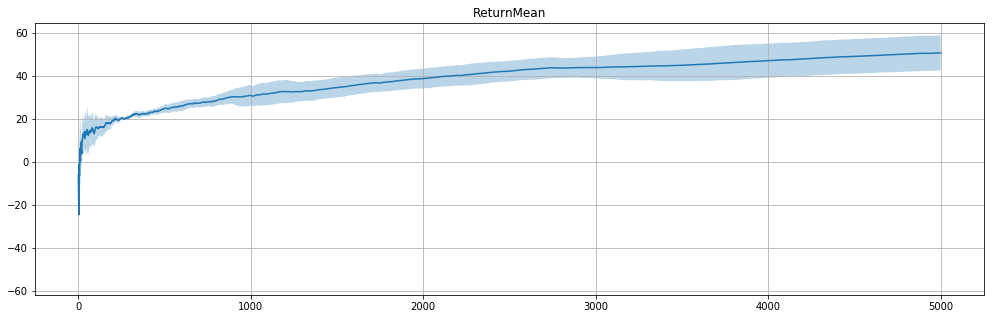

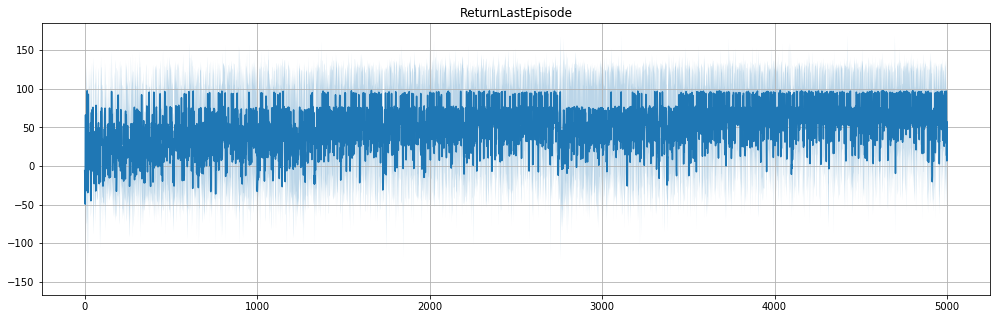

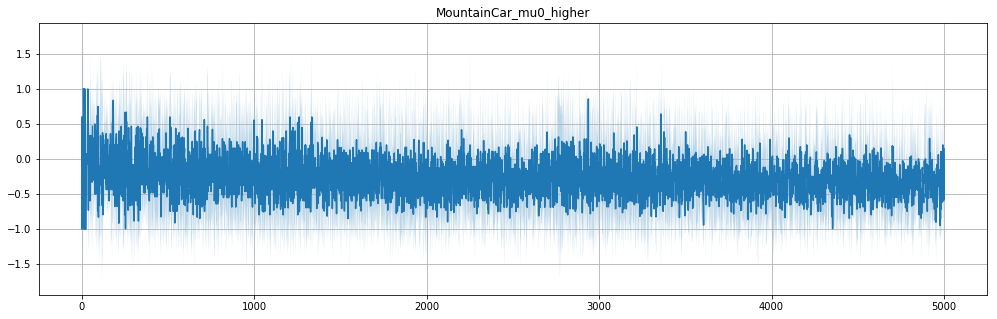

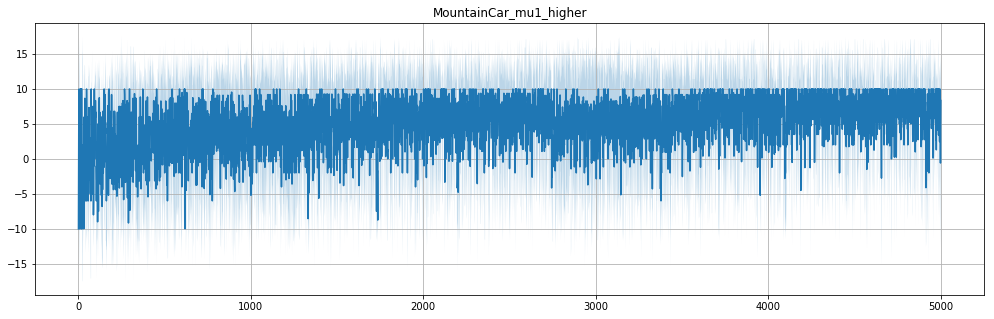

In [13]:
path_opt_ch ="./paper_figures/continuous_setting/mu/mc/optimist_experiment_mc_champagne/M*"
dfs_list_opt_ch, filenames_opt_ch = read_csv(path_opt_ch)
fig = plot_ci(dfs_list_opt_ch, conf=0.95, key='ReturnMean', ylim=None, scale='Iteration', title=None, grid=True)
fig = plot_ci(dfs_list_opt_ch, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration', title=None, grid=True)
fig = plot_ci(dfs_list_opt_ch, conf=0.95, key='MountainCar_mu0_higher', ylim=None, scale='Iteration', title=None, grid=True)
fig = plot_ci(dfs_list_opt_ch, conf=0.95, key='MountainCar_mu1_higher', ylim=None, scale='Iteration', title=None, grid=True)


PLotting a CI calculated with 5 runs with different seeds
PLotting a CI calculated with 5 runs with different seeds


/home/lupol/.local/lib/python3.5/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


PLotting a CI calculated with 5 runs with different seeds
PLotting a CI calculated with 5 runs with different seeds


/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1903: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/lupol/.local/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


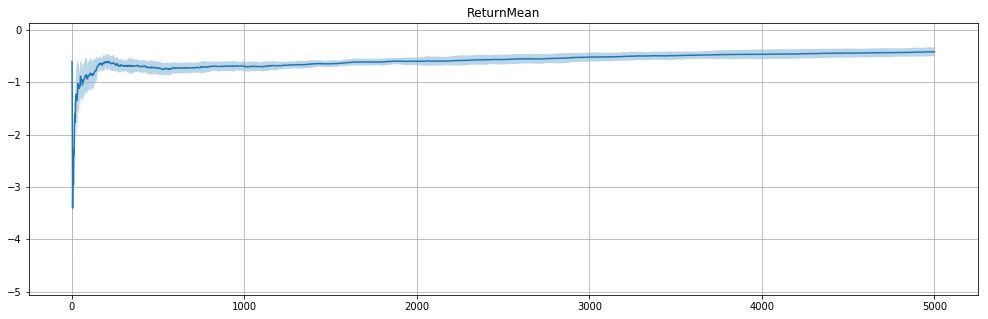

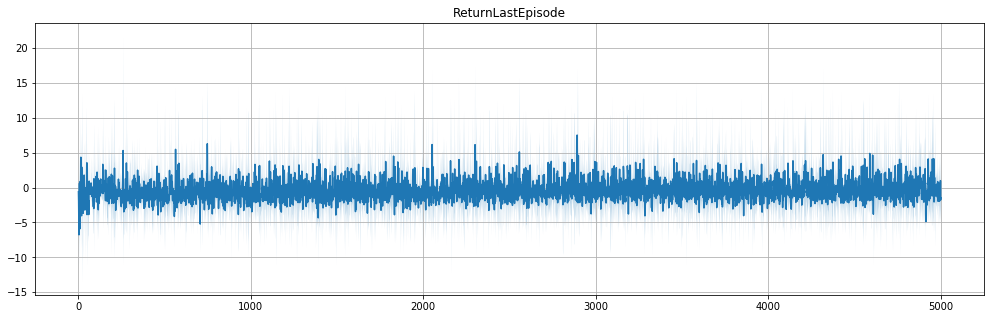

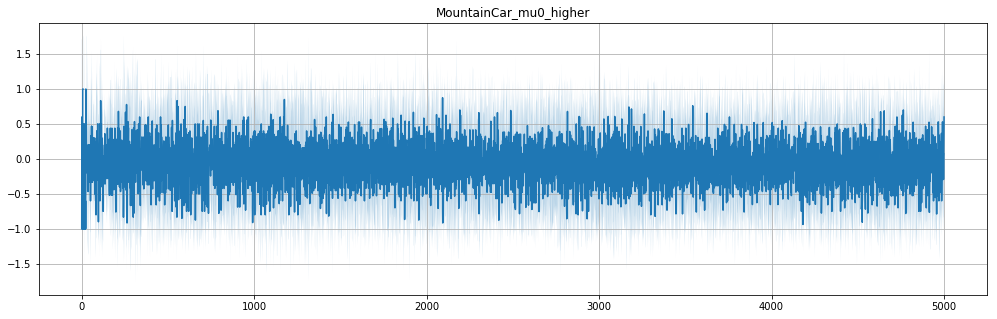

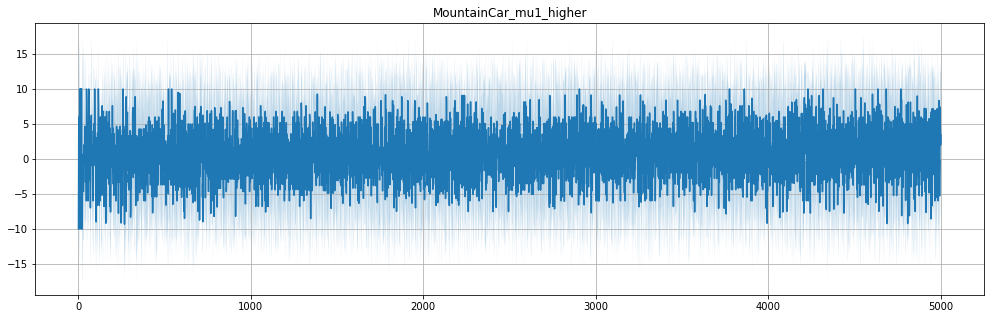

In [3]:
path_opt ="./paper_figures/continuous_setting/mu/mc/optimist_experiment_mc_k3_std3/M*"
dfs_list_opt, filenames_opt = read_csv(path_opt)
fig = plot_ci(dfs_list_opt, conf=0.95, key='ReturnMean', ylim=None, scale='Iteration', title=None, grid=True)
fig = plot_ci(dfs_list_opt, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration', title=None, grid=True)
fig = plot_ci(dfs_list_opt, conf=0.95, key='MountainCar_mu0_higher', ylim=None, scale='Iteration', title=None, grid=True)
fig = plot_ci(dfs_list_opt, conf=0.95, key='MountainCar_mu1_higher', ylim=None, scale='Iteration', title=None, grid=True)

# OPTIMIST k3 VS PGPE

OPTIMIST: 50.661414 ± 6.568468	[42.505583, 58.817244]	 total horizon: 5000
PGPE: 87.999884 ± 2.672706	[84.681280, 91.318487]	 total horizon: 50


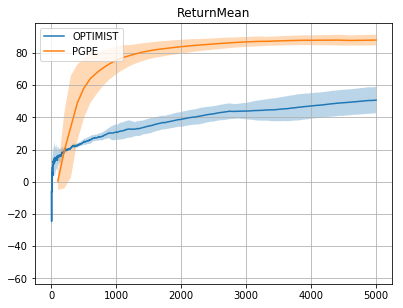

In [25]:
path0 ="./paper_figures/continuous_setting/mu/mc/pgpe_experiment_mc_findstep_champagne/MOUNTAINCARCONTINUOUS-V0_step=0.1*"
path_opt ="./paper_figures/continuous_setting/mu/mc/optimist_experiment_mc_champagne/M*"
dfs_list0, filenames0 = read_csv(path0)
dfs_list_opt, filenames_opt = read_csv(path_opt)

candidates = {'OPTIMIST': dfs_list_opt, 'PGPE': dfs_list0}
# candidates = {'OPTIMIST': dfs_listà_opt, 'OPTIMIST_champagne': dfs_list_opt_ch, 'PGPE': dfs_list0}
fig = compare(candidates, conf=0.95, key='ReturnMean', ylim=None, xlim=None, scale='NumTrajectories')

PLotting a CI calculated with 5 runs with different seeds
PLotting a CI calculated with 5 runs with different seeds
PLotting a CI calculated with 5 runs with different seeds


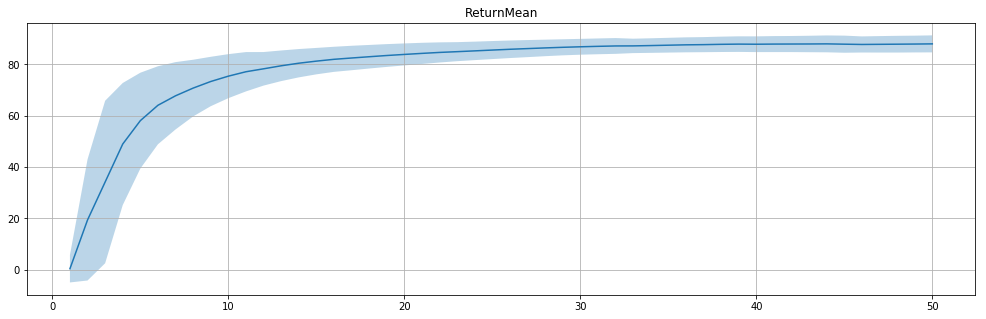

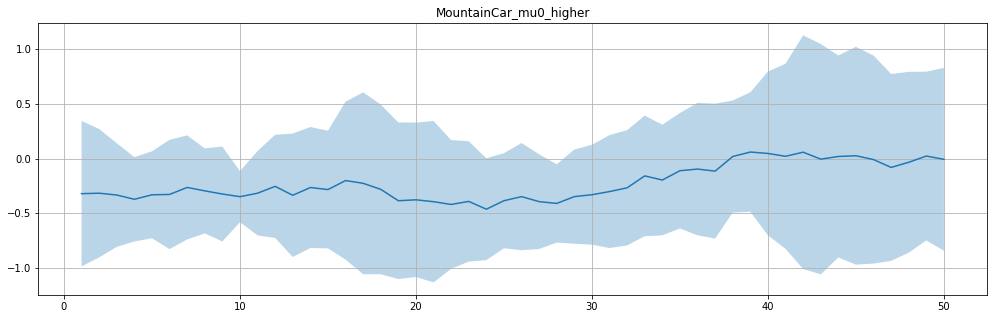

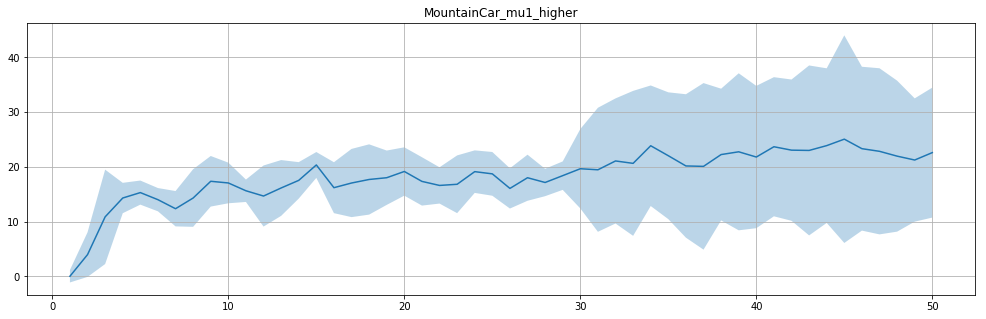

In [23]:
path0 ="./paper_figures/continuous_setting/mu/mc/pgpe_experiment_mc_findstep_champagne/MOUNTAINCARCONTINUOUS-V0_step=0.1*"
dfs_list0, filenames0 = read_csv(path0)
fig = plot_ci(dfs_list0, conf=0.95, key='ReturnMean', ylim=None, scale='Iteration', title=None, grid=True)
# fig = plot_ci(dfs_list0, conf=0.95, key='ReturnLastEpisode', ylim=None, scale='Iteration', title=None, grid=True)
fig = plot_ci(dfs_list0, conf=0.95, key='MountainCar_mu0_higher', ylim=None, scale='Iteration', title=None, grid=True)
fig = plot_ci(dfs_list0, conf=0.95, key='MountainCar_mu1_higher', ylim=None, scale='Iteration', title=None, grid=True)

OPTIMIST: -0.422543 ± 0.068946	[-0.508151, -0.336936]	 total horizon: 5000
PGPE: -0.147576 ± 0.082304	[-0.249770, -0.045381]	 total horizon: 50


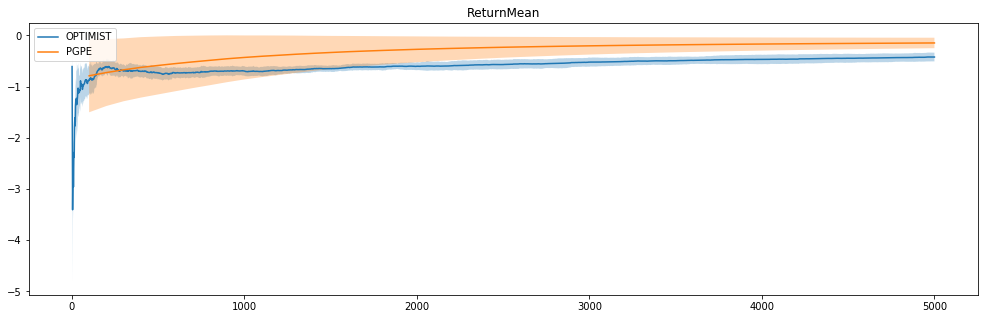

In [11]:
path0 ="./paper_figures/continuous_setting/mu/mc/pgpe_experiment_mc_findstep/MOUNTAINCARCONTINUOUS-V0_step=1*"
path_opt ="./paper_figures/continuous_setting/mu/mc/optimist_experiment_mc_k3_std3/M*"
dfs_list0, filenames0 = read_csv(path0)
dfs_list_opt, filenames_opt = read_csv(path_opt)

candidates = {'OPTIMIST': dfs_list_opt, 'PGPE': dfs_list0}
# candidates = {'OPTIMIST': dfs_listà_opt, 'OPTIMIST_champagne': dfs_list_opt_ch, 'PGPE': dfs_list0}
fig = compare(candidates, conf=0.95, key='ReturnMean', ylim=None, xlim=None, scale='NumTrajectories')

# PGPE step_size analysis

pgpe1: 87.999884 ± 2.672706	[84.681280, 91.318487]	 total horizon: 50
pgpe3: 11.561765 ± 14.797822	[-6.812158, 29.935689]	 total horizon: 50
pgpe2: 70.478263 ± 15.018474	[51.830364, 89.126161]	 total horizon: 50
pgpe0: -65335670150033304.000000 ± 146094999810978400.000000	[-246736571732911264.000000, 116065231432844640.000000]	 total horizon: 50
PLotting a CI calculated with 5 runs with different seeds
PLotting a CI calculated with 5 runs with different seeds
PLotting a CI calculated with 5 runs with different seeds


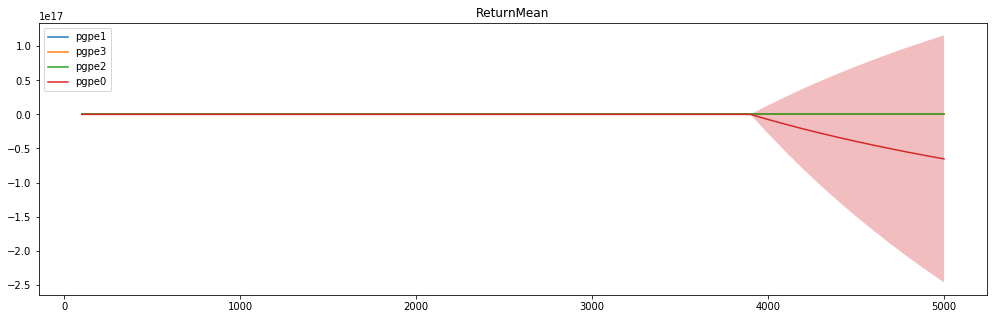

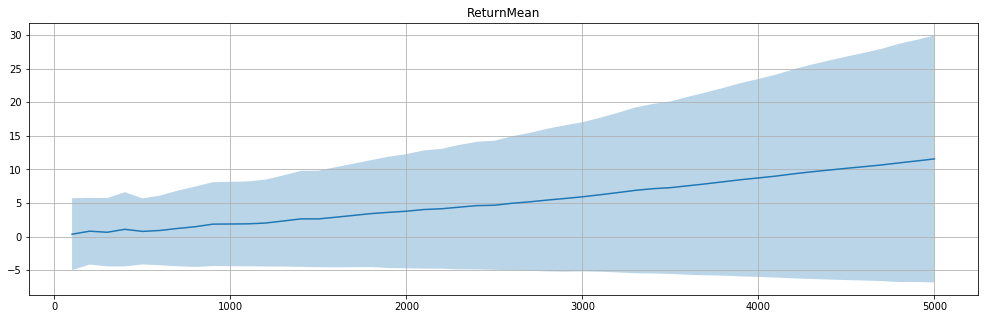

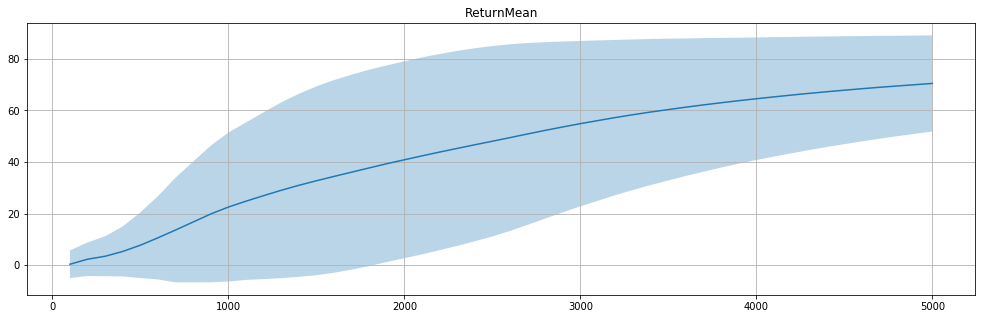

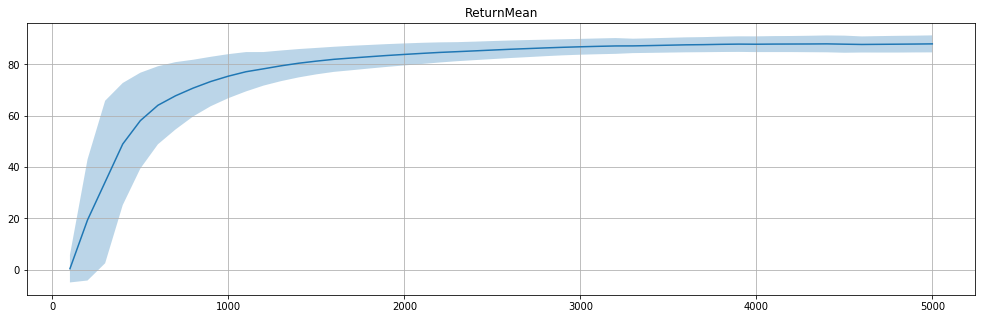

In [18]:
path3 ="./paper_figures/continuous_setting/mu/mc/pgpe_experiment_mc_findstep_champagne/MOUNTAINCARCONTINUOUS-V0_step=0.001*"
path2 ="./paper_figures/continuous_setting/mu/mc/pgpe_experiment_mc_findstep_champagne/MOUNTAINCARCONTINUOUS-V0_step=0.01*"
path1 ="./paper_figures/continuous_setting/mu/mc/pgpe_experiment_mc_findstep_champagne/MOUNTAINCARCONTINUOUS-V0_step=0.1*"
path0 ="./paper_figures/continuous_setting/mu/mc/pgpe_experiment_mc_findstep_champagne/MOUNTAINCARCONTINUOUS-V0_step=1*"
dfs_list3, filenames3 = read_csv(path3)
dfs_list2, filenames2 = read_csv(path2)
dfs_list1, filenames1 = read_csv(path1)
dfs_list0, filenames0 = read_csv(path0)
candidates = {'pgpe3': dfs_list3, 'pgpe2': dfs_list2, 'pgpe1': dfs_list1, 'pgpe0': dfs_list0}
fig = compare(candidates, conf=0.95, key='ReturnMean', ylim=None, xlim=None, scale='NumTrajectories')
fig = plot_ci(dfs_list3, conf=0.95, key='ReturnMean', ylim=None, scale='NumTrajectories', title=None, grid=True)
fig = plot_ci(dfs_list2, conf=0.95, key='ReturnMean', ylim=None, scale='NumTrajectories', title=None, grid=True)
fig = plot_ci(dfs_list1, conf=0.95, key='ReturnMean', ylim=None, scale='NumTrajectories', title=None, grid=True)
# fig = plot_ci(dfs_list0, conf=0.95, key='ReturnMean', ylim=None, scale='NumTrajectories', title=None, grid=True)


# IvertedPendulum - mu only

 The (almost) optimal parameters found by PPO are:
- mu ~ [-1.5666753  -1.2310921  -0.04226363 -1.8523657]
- std ~ 0.8

Hence, we can search them in the $[-2,2]^2$ box.

### OPTIMIST vs PGPE on IvertedPendulum

In [27]:
# path1 ="./paper_figures/continuous_setting/mu/pgpe_experiment_ip/RLLAB.INVERTED_PENDULUM_step=0.1*"
# path_opt ="./paper_figures/continuous_setting/mu/pbpoise_experiment_ip__k4_5000it/R*"
# dfs_list1, filenames1 = read_csv(path1)
# dfs_list_opt, filenames_opt = read_csv(path_opt)
# candidates = {'OPTIMIST': dfs_list_opt, 'PGPE': dfs_list1}
# fig = compare(candidates, conf=0.95, key='ReturnMean', ylim=None, xlim=None, scale='NumTrajectories')
# fig = compare(candidates, conf=0.95, key='Iteration', ylim=None, xlim=None, scale='NumTrajectories')

In [28]:
# path_opt ="./paper_figures/continuous_setting/mu/pbpoise_experiment_ip__k4_5000it/R*"
# dfs_list_opt, filenames_opt = read_csv(path_opt)
# fig = plot_ci(dfs_list_opt, conf=0.95, key='InvPendulum_mu1_higher', ylim=None, scale='Iteration', title=None, grid=True)

### PGPE on IvertedPendulum - step_size tuning

In [29]:
# path4 ="./paper_figures/continuous_setting/mu/pgpe_experiment_ip/RLLAB.INVERTED_PENDULUM_step=0.0001*"
# path3 ="./paper_figures/continuous_setting/mu/pgpe_experiment_ip/RLLAB.INVERTED_PENDULUM_step=0.001*"
# path2 ="./paper_figures/continuous_setting/mu/pgpe_experiment_ip/RLLAB.INVERTED_PENDULUM_step=0.01*"
# path1 ="./paper_figures/continuous_setting/mu/pgpe_experiment_ip/RLLAB.INVERTED_PENDULUM_step=0.1*"
# path0 ="./paper_figures/continuous_setting/mu/pgpe_experiment_ip/RLLAB.INVERTED_PENDULUM_step=1*"
# dfs_list4, filenames4 = read_csv(path4)
# dfs_list3, filenames3 = read_csv(path3)
# dfs_list2, filenames2 = read_csv(path2)
# dfs_list1, filenames1 = read_csv(path1)
# dfs_list0, filenames0 = read_csv(path0)
# candidates = {'pgpe4': dfs_list4, 'pgpe3': dfs_list3, 'pgpe2': dfs_list2, 'pgpe1': dfs_list1, 'pgpe0': dfs_list0}
# fig = compare(candidates, conf=0.95, key='ReturnMean', ylim=None, xlim=None, scale='NumTrajectories')
# fig = compare(candidates, conf=0.95, key='Iteration', ylim=None, xlim=None, scale='NumTrajectories')
# fig = compare(candidates, conf=0.95, key='AvgEpLen', ylim=None, xlim=None, scale='NumTrajectories')